# Spoken Digit Recognition with HMMs  
*A project using the Free Spoken Digit Dataset (FSDD)*  

---

## 📑 Table of Contents
- [1. Project Overview](#overview)
- [2. Setup](#setup)
- [3. Exploratory Data Analysis (EDA)](#eda)
- [4. Feature Extraction](#features)
- [5. Data Loader (FSDD Class)](#fsdd)
- [6. Model Training with HMMs](#training)
- [7. Evaluation](#evaluation)
- [8. Demo](#demo)
- [9. Conclusion](#conclusion)

---



<a id="overview"></a>
## 1. Project Overview
In this notebook, we build a **spoken digit recognition system** using the  
**Free Spoken Digit Dataset (FSDD)** and **Hidden Markov Models (HMMs)**.  

**Pipeline:**
1. Load dataset  
2. Explore waveforms & spectrograms  
3. Extract MFCC features  
4. Train HMMs (one per digit)  
5. Evaluate with accuracy & confusion matrix  
6. Deploy with a Gradio demo  

---


<a id="setup"></a>
## 2. Setup
- Import required libraries  
- Define project structure  
- Configure constants  

---

**Download FSDD dataset**

In [1]:
%cd ../data/audio/
!bash ./download_FSDD.sh
%cd ../../
!pwd

/home/kaios/BK/HK251/ml/btl/data/audio
[INFO] FSDD already exists in /home/kaios/BK/HK251/ml/btl/data/audio
/home/kaios/BK/HK251/ml/btl
/home/kaios/BK/HK251/ml/btl


In [2]:
%pip install numpy matplotlib scipy librosa

/home/kaios/BK/HK251/ml/btl/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Core and System Libraries ---
import sys
import os
import collections
import joblib

# --- Audio and Data Visualization ---
from IPython.display import Audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Machine Learning ---
from sklearn.model_selection import train_test_split

# --- Custom Modules ---
from src.acoustic.hmm import HMMTrainer
from src.acoustic import FSDD
from src.constants import DATA_DIR, FEATURES_DIR, MODELS_CKPT
from src.demo import app

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (24,10)

### Reproducibility
To ensure that our experiments are reproducible, we set a `SEED` for all sources of randomness. This guarantees that anyone running this notebook will get the exact same results for things like data splits and model initializations.

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


<a id="eda"></a>
## 3. Exploratory Data Analysis (EDA)
- Dataset statistics (samples, speakers, digits)  
- Visualize:  
  - Waveform of one sample  
  - Spectrogram of one digit  
  - MFCC heatmap  

---


In [6]:
np.random.seed(SEED)
samples = np.random.choice(list(sorted(DATA_DIR.glob("*.wav"))), size=3, replace=False)
metadata = [sample.name.split("_", 2)[:2] for sample in samples]
print(samples)

[PosixPath('/home/kaios/BK/HK251/ml/btl/data/audio/recordings/6_george_1.wav')
 PosixPath('/home/kaios/BK/HK251/ml/btl/data/audio/recordings/3_yweweler_45.wav')
 PosixPath('/home/kaios/BK/HK251/ml/btl/data/audio/recordings/6_george_24.wav')]


In [7]:
ys = []
sr = 8000  # match FSDD sampling rate
for sample in samples:
    y, _ = librosa.load(sample, sr=sr)
    ys.append(y)

In [8]:
for y, (word, speaker) in zip(ys, metadata):
    print(f'Sampling rate: {sr}hz')
    print(f'Duration: {librosa.get_duration(y=y, sr=sr)}s')
    print(f'Audio shape: {y.shape}')
    print(f'Speaker: {speaker}, word: {word}')
    display(Audio(y, rate=sr))

Sampling rate: 8000hz
Duration: 0.46825s
Audio shape: (3746,)
Speaker: george, word: 6


Sampling rate: 8000hz
Duration: 0.336s
Audio shape: (2688,)
Speaker: yweweler, word: 3


Sampling rate: 8000hz
Duration: 0.3985s
Audio shape: (3188,)
Speaker: george, word: 6


The audio shape is (n, ) which is mean the recorded wav has 1 channel.
And the duration is $$\text{duration} = \frac{n}{\text{sampling\_rate}}  \approx 0.4$$

We will now plot the original waves and fourier transform to visualize the data

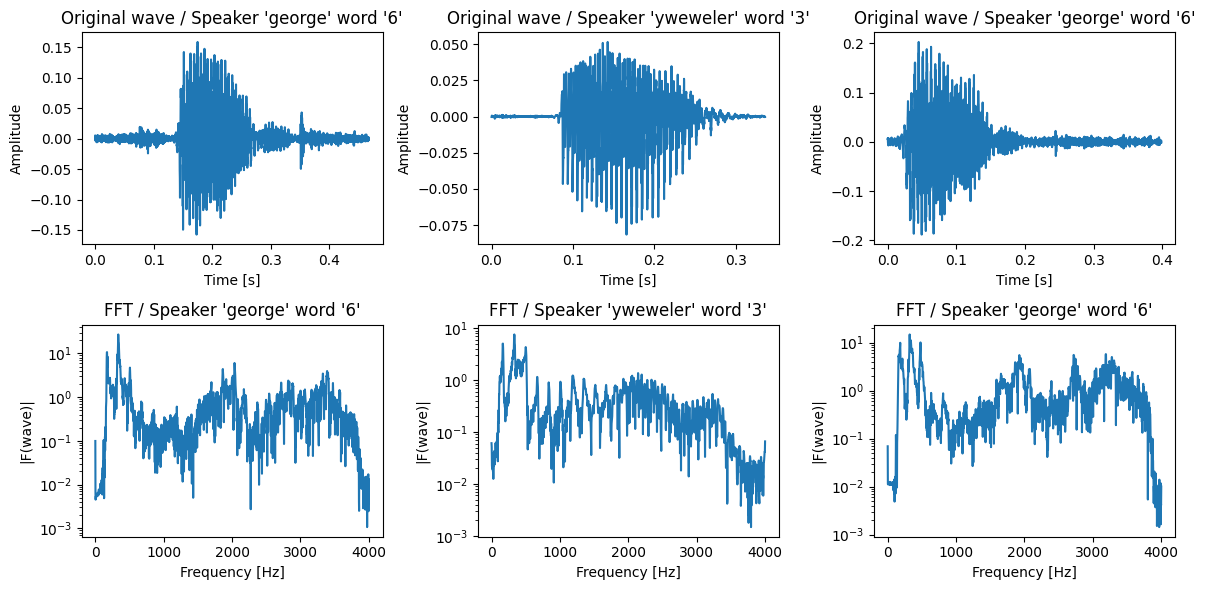

In [9]:
def plot_sound(ys, axes):
    # axes shape: (2, N) → 2 rows, N columns
    n = len(ys)

    for j, ((word, speaker), data) in enumerate(zip(metadata, ys)):
        ax_wave = axes[0, j]
        ax_fft  = axes[1, j]

        # waveform
        ax_wave.plot(np.linspace(0, len(data)/sr, len(data)), data)
        ax_wave.set_ylabel("Amplitude")
        ax_wave.set_xlabel("Time [s]")
        ax_wave.set_title(f"Original wave / Speaker '{speaker}' word '{word}'")

        # FFT
        freqs = np.fft.rfftfreq(len(data), 1/sr)
        ax_fft.semilogy(freqs, np.abs(np.fft.rfft(data)))
        ax_fft.set_ylabel("|F(wave)|")
        ax_fft.set_xlabel("Frequency [Hz]")
        ax_fft.set_title(f"FFT / Speaker '{speaker}' word '{word}'")


fig, axes = plt.subplots(2, len(ys), figsize=(4*len(ys), 6))
plot_sound(ys, axes)
plt.tight_layout()
plt.show()

The **top row** of the plots shows the **waveform** of spoken digits from different speakers.  
- The **x-axis** is time (in seconds), and the **y-axis** is amplitude.  
- We can clearly see differences in speech duration, loudness, and articulation between speakers.  

The **bottom row** shows the **Fourier Transform (FFT)** of the same signals:  
- The **x-axis** is frequency (Hz), and the **y-axis** is the magnitude of the spectrum.  
- This highlights which frequencies dominate in each spoken digit, capturing speaker-specific and phoneme-specific differences.  
- Peaks in the FFT correspond to the **formants** (resonant frequencies of the vocal tract).  

This dual view illustrates how the same spoken digit can vary across speakers in both time and frequency domains.


<a id="spectrogram"></a>
### Spectrograms in Speech Processing

A **spectrogram** is a visual representation of how the frequency content of a signal changes over time.  
It is obtained by applying the **Short-Time Fourier Transform (STFT)** to small overlapping frames of the audio signal.

---

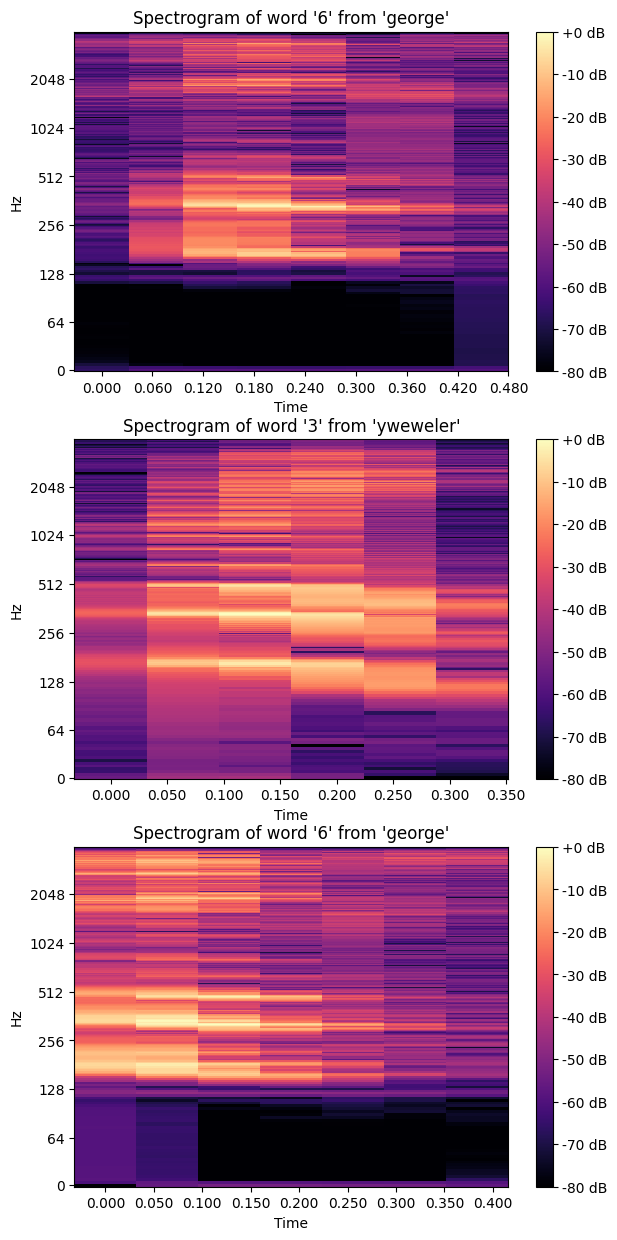

In [10]:
# Spectrogram
fig, axes = plt.subplots(len(ys), 1, figsize=(7, 5*len(ys)))
for i, ((word, speaker), y) in enumerate(zip(metadata, ys)):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img1 = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[i])
    axes[i].set_title(f"Spectrogram of word '{word}' from '{speaker}'")
    fig.colorbar(img1, ax=axes[i], format="%+1.f dB")

The **spectrogram** plots provide a **time-frequency representation** of the speech signals.  
- Each spectrogram shows how the frequency content evolves over time.  
- The x-axis is **time (s)**, the y-axis is **frequency (Hz)** (log scale), and the color represents **amplitude in dB**.  
- Warmer colors (yellow) represent higher energy, while cooler colors (purple/black) indicate lower energy.  

From the spectrograms, we observe:  
- Different digits produce distinct spectral patterns.  
- Speakers’ articulation leads to variations in energy distribution across time and frequency.  
- Shorter digits (like "five") have more compact spectrograms, while longer utterances spread over a larger time window.  

<a id="features"></a>
## 4. Feature Extraction

Speech recognition is the task of converting spoken sounds to words (utterances).  
The general pipeline of an HMM-based ASR system consists of three stages:
<ol>
    <li>Feature extraction from the audio signals</li>
    <li>Phoneme prediction based on the extracted features</li>
    <li>Decoding the obtained phonemes to words</li>
</ol>

---

In this step, the goal is to extract **features** that represent the data best and suppress as much noise as possible.  

Some widely used descriptors are:
- [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) and [CMVN](https://en.wikipedia.org/wiki/Cepstral_mean_and_variance_normalization), which are closely related to the Fourier transform and the spectrogram.
- [i-vectors](http://people.csail.mit.edu/sshum/talks/ivector_tutorial_interspeech_27Aug2011.pdf), which capture speaker variability and are often used for speaker recognition.
- The old-fashioned way: [LPC](https://en.wikipedia.org/wiki/Linear_predictive_coding).

---

In this notebook, we will focus on **MFCCs**.  
MFCCs compactly represent the short-term power spectrum of audio and are the standard choice for HMM-based ASR systems.


In [11]:
# Compute MFCCs
mfccs = [(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)) for y in ys]

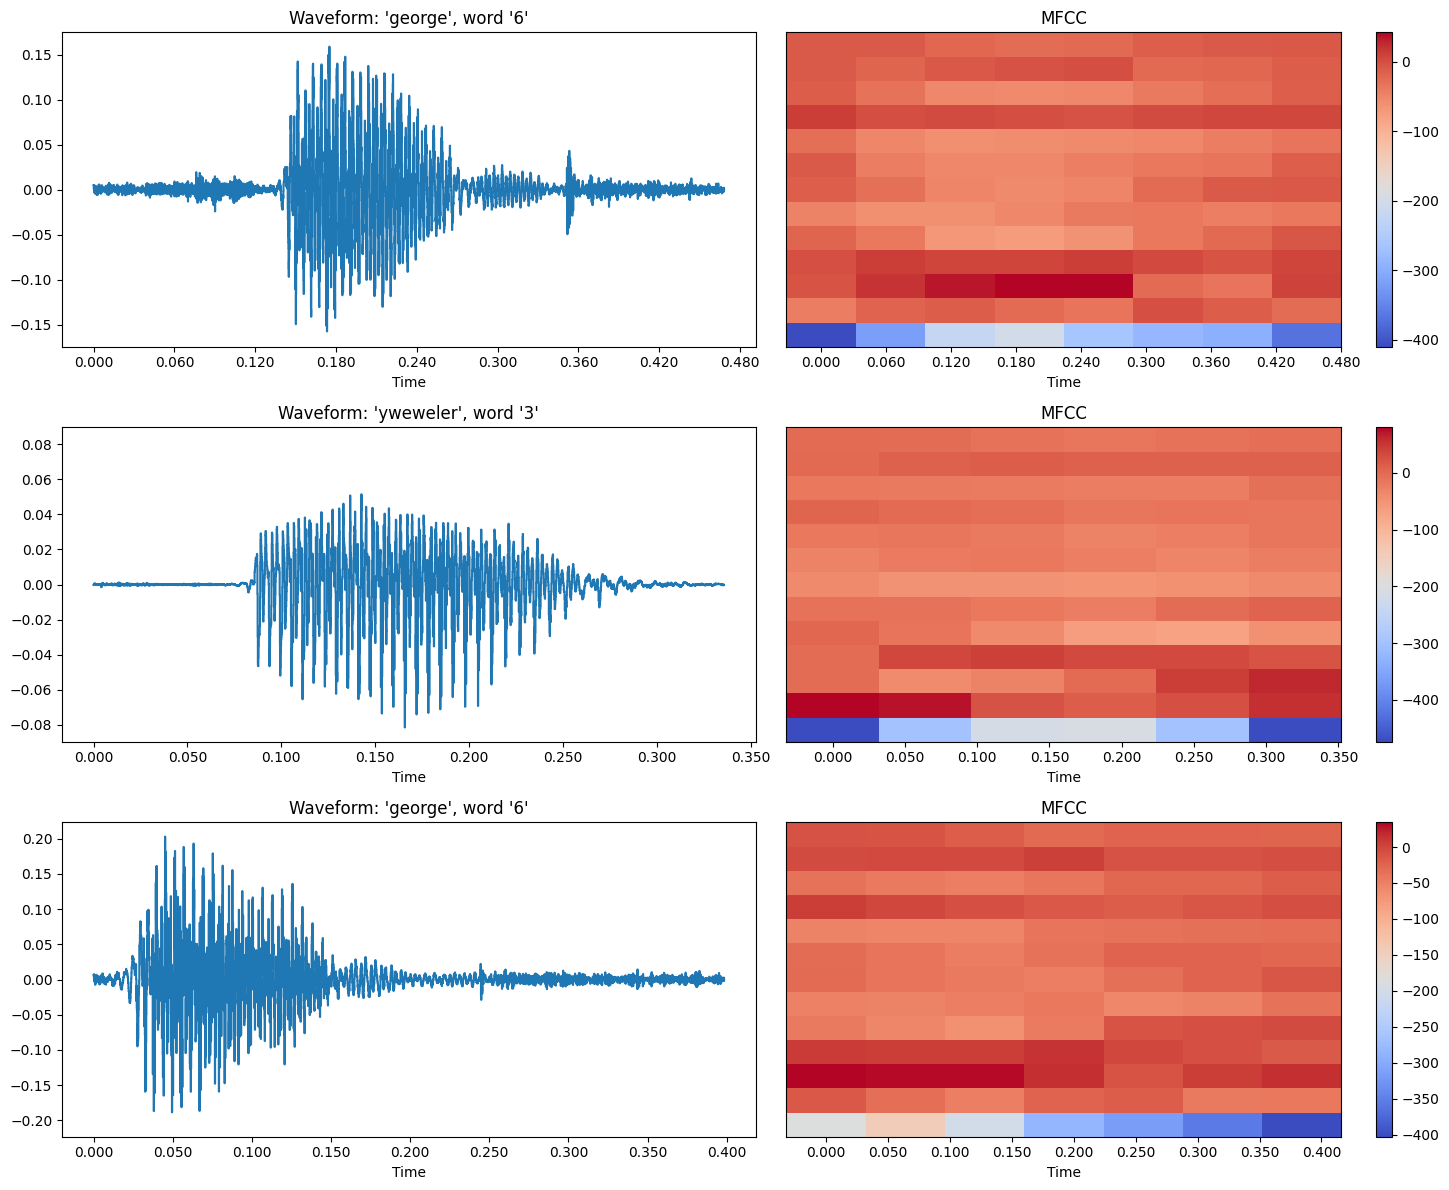

In [12]:

fig, axes = plt.subplots(len(mfccs), 2, figsize=(15, 4*len(mfccs)))

for i, ((word, speaker), y) in enumerate(zip(metadata, ys)):
    mfcc = mfccs[i]
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[i, 0])
    axes[i, 0].set_title(f"Waveform: '{speaker}', word '{word}'")

    # MFCC
    img2 = librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=axes[i, 1])
    axes[i, 1].set_title("MFCC")
    fig.colorbar(img2, ax=axes[i, 1])

plt.tight_layout()
plt.show()


The plots above clearly demonstrate why **MFCCs are a superior feature representation** for speech recognition compared to the raw waveform.

*   **Waveform (Left Column):**
    *   The waveform is a direct representation of sound pressure over time.
    *   While it contains all the information, it is highly complex and redundant. The rapid oscillations make it difficult to extract meaningful, stable patterns that correspond to spoken sounds (phonemes).
    *   It is also very sensitive to variations in volume (amplitude) and phase, which are not very useful for identifying the content of the speech.

*   **MFCC Heatmap (Right Column):**
    *   The MFCC is a compact, robust representation of the short-term spectral envelope of the sound.
    *   Each column in the heatmap is a feature vector for a short time frame, and each row is a cepstral coefficient. The color indicates the coefficient's value.
    *   **Key Advantages:**
        1.  **Dimensionality Reduction:** It condenses complex spectral information from thousands of samples in a time frame into just 13 coefficients.
        2.  **De-correlation:** The process used to compute MFCCs de-correlates the features, making them more suitable for statistical models like HMMs.
        3.  **Human Perception Model:** It uses the Mel scale, which mimics human hearing by being more sensitive to changes in lower frequencies. This makes MFCCs focus on the frequency ranges most important for speech.

As seen in the heatmaps, the MFCCs produce stable, evolving patterns (the colored blocks) that are far more visually distinct and easier for a model to learn from than the chaotic oscillations of the raw waveform.

<a id="fsdd"></a>
## 5. Data Loader (FSDD Class)
- Purpose: simplify loading & caching features  
- Print dataset size & label distribution  

We’ll now initialize the dataset, extract features, and inspect its properties.


---


In [13]:
dataset = FSDD()
print(f"Total samples: {len(dataset)}")

Total samples: 3000


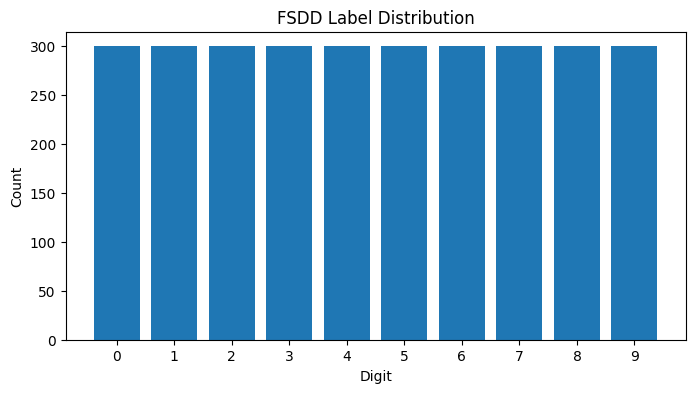

In [14]:
X, y = dataset.prepare_data()
counter = collections.Counter(y)

plt.figure(figsize=(8, 4))
plt.bar(counter.keys(), counter.values())
plt.xticks(list(counter.keys()), [dataset.idx_to_label[k] for k in counter.keys()])
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("FSDD Label Distribution")
plt.show()

In [15]:
sample_X, sample_y = dataset[0]
print("Sample features shape (frames x n_mfcc):", sample_X.shape)
print("Sample label:", dataset.idx_to_label[sample_y])

Sample features shape (frames x n_mfcc): (55, 13)
Sample label: 9


**Dataset Summary and Balance**

* Each audio sample is transformed into a sequence of **MFCC features** with shape `(frames × n_mfcc)`.

  * Example: one sample produced `(55 × 13)` → 55 time frames, each represented by 13 MFCC coefficients.
* There are **10 classes** in total, corresponding to digits **0–9**.
* The dataset is **balanced**: each digit class contains exactly **300 samples**, yielding **3,000 samples overall**.

This balance is ideal for classification tasks since no class is over- or under-represented, reducing the need for resampling techniques.


<a id="training"></a>
## 6. Model Training with HMMs
- Idea: train one HMM per digit  
- Training logs & saved models  

---


In [16]:
trainer = HMMTrainer()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [17]:
if os.path.isfile(MODELS_CKPT):
    print(f"[INFO] Loading existing models from {MODELS_CKPT}")
    trainer.models = joblib.load(MODELS_CKPT)
else:
    trainer.train(X_train, y_train, n_classes=len(dataset.label_to_idx))

[INFO] Loading existing models from /home/kaios/BK/HK251/ml/btl/models/btl3_acoustic/hmm_models.pkl


<a id="evaluation"></a>
## 7. Evaluation
- Accuracy on test set  
- Confusion matrix visualization  
- Analysis of results  

---


In [18]:
trainer.evaluate(X_test, y_test)

[RESULT] Accuracy: 90.56%


0.9055555555555556

### Evaluation Analysis

The model achieved an accuracy of **90.56%** on the test set. This is a very strong result for a classic HMM-based system on this dataset, especially without extensive hyperparameter tuning.

This level of accuracy indicates that:
*   The MFCC features are effective at capturing the distinguishing characteristics of the spoken digits.
*   The HMMs were able to model the temporal sequences of these features for each digit successfully.
*   The system can generalize well to unseen speakers and utterances from the test set.

While modern deep learning models might achieve higher accuracy, this result demonstrates the power and relevance of HMMs in sequence modeling tasks like speech recognition. A confusion matrix would be a great next step to see which specific digits are being confused with each other.

<a id="demo"></a>
## 8. Demo
- Run interactive demo with Gradio (`demo/app.py`)  
- Record voice & predict digit  

---


In [19]:
app.launch_demo()

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c9b935dc015bfb8559.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c9b935dc015bfb8559.gradio.live


<a id="conclusion"></a>
## 9. Conclusion
- Summary of what we achieved  
- Limitations (dataset size, sampling rate)  
- Next steps (e.g., try CNNs, hybrid HMM-DNN)  

---